In [1]:
import numpy as np
import pandas as pd
import os
import argparse

import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

from scipy.stats import pearsonr, linregress

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

def autopct_format(values):
    def my_format(pct):
        absolute = round(pct / 100. * sum(values))
        return f"{absolute} ({pct:.1f}%)"
    return my_format

# We inspect the full clinical sample, without filters

In [2]:
root = "/home/sano/Documents/Joan/Data/Glioblastoma_UPENN-GBM_v2-20221024"
figs = os.path.join(root, "Figures")
os.makedirs(figs, exist_ok=True)
clinical_raw_full = pd.read_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v2.1.csv"), sep=',')
clinical_raw_full.head()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,960,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,2838,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,623,Deceased,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,1143,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


There is an earlier version for the clinical data named v1.0. Even though we will work with the version 2.1, we will load the earlier version to keep track of the changes w.r.t. the publication describing the dataset (Bakas, et al. 2022).

In [3]:
clinical_raw_full_1 = pd.read_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v1.0.csv"), sep=',')
clinical_raw_full_1.head()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


There is also a csv file that describes the data available for each subject. However, the new version does not adequately correspond to the UPDATED version of the of the dataset. In fact, the available survival data for the new version of the data is much higher than the 452 reported in Bakas, et al. 2022.

In [4]:
available_data = pd.read_csv(os.path.join(root, "data/UPENN-GBM_data_availability.csv"), sep=',')
available_data.groupby(["Overall Survival"])["MGMT"].count()

Overall Survival
available        452
not available    219
Name: MGMT, dtype: int64

In [5]:
print("Survival data for version 1.0: ", len(clinical_raw_full_1.loc[clinical_raw_full_1["Survival_from_surgery_days"]!="Not Available"]))
print("Survival data for version 1.0: ", len(clinical_raw_full_1.loc[clinical_raw_full["Survival_from_surgery_days_UPDATED"]!="Not Available"]))

Survival data for version 1.0:  452
Survival data for version 1.0:  644


The other source of conflict that we identified w.r.t. Bakas, et al. 2022 is the MGMT promoter identification. However, there is no way to reconcile the data present in both versions with the numbers reported in the publication. 
It is possible that a mistake was made and we should notify the authors.

In [6]:
available_data1 = pd.read_csv(os.path.join(root, "data/UPENN-GBM_data_availability_v1.0.csv"), sep=',')
available_data1.loc[available_data1["Associated Baseline Scan"]=="-"].groupby(["MGMT"]).count()

,ID,Structural imaging,DTI imaging,DSC imaging,Automatic Tumor Segmentation,Corrected Tumor Segmentation,Gender,Age,Overall Survival,IDH1,KPS,Extent of Resection,Associated Baseline Scan,Associated Recurrence Scan,PsP_TP score,CaPTk Radiomic Features
MGMT,,,,,,,,,,,,,,,,
available,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262
not available,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349


In [7]:
available_data.loc[available_data["Associated Baseline Scan"]=="-"].groupby(["MGMT"]).count()

,ID,Structural imaging,DTI imaging,DSC imaging,Automatic Tumor Segmentation,Corrected Tumor Segmentation,Gender,Age,Overall Survival,IDH1,KPS,Extent of Resection,Associated Baseline Scan,Associated Recurrence Scan,PsP_TP score,CaPTk Radiomic Features
MGMT,,,,,,,,,,,,,,,,
available,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262
not available,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349


In [8]:
clinical_raw_full_1.loc[clinical_raw_full_1["Time_since_baseline_preop"]=="0"].groupby(["MGMT"]).count()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
MGMT,,,,,,,,,
Indeterminate,27,27,27,27,27,27,27,27,0
Methylated,111,111,111,111,111,111,111,111,0
Not Available,322,322,322,322,322,322,322,322,0
Unmethylated,151,151,151,151,151,151,151,151,0


In [9]:
clinical_raw_full.loc[clinical_raw_full["Time_since_baseline_preop"]=="0"].groupby(["MGMT"]).count()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
MGMT,,,,,,,,,,,
Indeterminate,27,27,27,27,27,27,27,27,27,27,0
Methylated,111,111,111,111,111,111,111,111,111,111,0
Not Available,322,322,322,322,322,322,322,322,322,322,0
Unmethylated,151,151,151,151,151,151,151,151,151,151,0


### We need to understand the meaning of follow-up times and scans in order to know whether they should be discarded or not

In [10]:
# Let's consider an example first
ex_available = available_data.loc[(available_data["ID"]=="UPENN-GBM-00352_11") | (available_data["ID"]=="UPENN-GBM-00352_21")]
ex_clinical = clinical_raw_full.loc[(clinical_raw_full["ID"]=="UPENN-GBM-00352_11") | (clinical_raw_full["ID"]=="UPENN-GBM-00352_21")]
ex_clinical

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
388,UPENN-GBM-00352_11,M,42.61,617,Deceased,Not Available,Wildtype,Unmethylated,90,Y,0,NaN
389,UPENN-GBM-00352_21,M,42.86,519,Deceased,Not Available,Wildtype,Methylated,Not Available,Not Applicable,91,4.0


In [11]:
ex_available

,ID,Structural imaging,DTI imaging,DSC imaging,Automatic Tumor Segmentation,Corrected Tumor Segmentation,Gender,Age,Overall Survival,IDH1,MGMT,KPS,Extent of Resection,Associated Baseline Scan,Associated Recurrence Scan,PsP_TP score,CaPTk Radiomic Features
351,UPENN-GBM-00352_11,available,available,available,available,not available,available,available,available,available,available,available,available,-,available,not available,available
648,UPENN-GBM-00352_21,available,available,available,not available,not available,available,available,not available,available,available,not available,not available,available,-,available,not available


### Getting the WHO 2021 classification of Glioblastomas

Let's discard the explicit follow-ups. They represent repeated entries. Even more, data was obtained after perturbation (prior surgery), therefore a separate description should be put in place.

In [12]:
clinical_raw = clinical_raw_full.copy()
clinical_raw = clinical_raw.loc[clinical_raw["Time_since_baseline_preop"]=="0"]
clinical_raw.head()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,960,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,2838,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,623,Deceased,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,1143,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


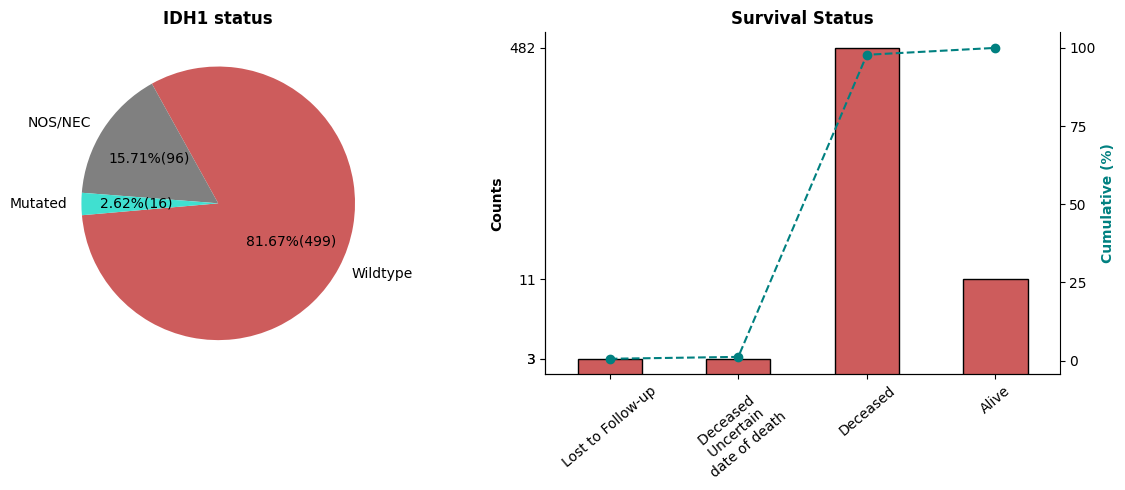

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

dt = clinical_raw["IDH1"].value_counts()
dt.plot.pie(
    ax=ax[0],
    labels=dt.keys(),
    autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
    colors=["indianred", "gray", "turquoise"],
    explode=[0, 0.0, 0.0],
    startangle=185
)
ax[0].set_title("IDH1 status", fontweight='bold')
ax[0].set_ylabel("")


dt = clinical_raw.loc[clinical_raw["IDH1"] == "Wildtype"]["Survival_Status"].value_counts()
dt = dt.sort_index(ascending=False)  # Reverse the order of bars
bars = dt.plot.bar(
    ax=ax[1],
    color="indianred",
    edgecolor="black"
)
ax[1].spines[["top", "right"]].set_visible(False)
ax[1].set_title("Survival Status", fontweight="bold")
ax[1].set_xlabel(None)
ax[1].set_ylabel("Counts", fontweight="bold")
ax[1].set_yscale("log")  # Semilogy scale
ax[1].set_yticks(dt.values)
ax[1].set_yticklabels([f"{val}" for val in dt.values])
ax[1].yaxis.set_minor_locator(plt.NullLocator())  # This disables the small y-tick marks
ax[1].set_xticklabels(["Lost to Follow-up","Deceased \nUncertain \ndate of death", "Deceased", "Alive"],rotation=40)

cumulative_percent = (dt.cumsum() / dt.sum()) * 100
ax2 = ax[1].twinx()
ax2.spines[["top"]].set_visible(False)
ax2.plot(
    cumulative_percent.index,
    cumulative_percent,
    color="teal",
    linestyle="--",
    marker="o",
    label="Cumulative (%)"
)
ax2.set_ylabel("Cumulative (%)", fontweight="bold", color="teal")
ax2.set_yticks([0,25,50,75,100])

fig.tight_layout()

### We extract the patients with confirmed GBM Widltype and available survival data

Let's also consider the patients with a confirmed WHO 2021 glioblastoma diagnosis and available (or usable) survival data.

In [14]:
glioblastoma2021_sample = clinical_raw.loc[(clinical_raw["IDH1"]=="Wildtype") & (clinical_raw["Survival_Status"]!="Deceased - uncertain date of death")]

# Change to 1-dead / 0-alive or lost to follow-up
glioblastoma2021_survival = glioblastoma2021_sample.copy()
glioblastoma2021_survival["Survival_Status"] = glioblastoma2021_sample["Survival_Status"].apply(
    lambda x: 1 if x == "Deceased" else 0
)

# Move the censoring time to the "survival in days" column
glioblastoma2021_OS = glioblastoma2021_survival.copy()
glioblastoma2021_OS.loc[
    glioblastoma2021_OS["Survival_Status"] == 0, 
    "Survival_from_surgery_days_UPDATED"
] = glioblastoma2021_OS["Survival_Censor"]

# Drop useless columns
glioblastoma2021_OS = glioblastoma2021_OS.drop(columns=["Survival_Censor", "IDH1","Time_since_baseline_preop","PsP_TP_score"])
glioblastoma2021_OS.to_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v3.0.csv"), index=None)
glioblastoma2021_OS.groupby(["MGMT"], dropna=False).count()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,KPS,GTR_over90percent
MGMT,,,,,,,
Indeterminate,25,25,25,25,25,25,25
Methylated,103,103,103,103,103,103,103
Not Available,217,217,217,217,217,217,217
Unmethylated,151,151,151,151,151,151,151


Do all of these patients have available preop imaging data?

In [15]:
total = 0
for subject in glioblastoma2021_OS.iloc:
    ID = subject["ID"]
    df = available_data.loc[available_data["ID"]==ID]
    df = df[["ID","Structural imaging","Automatic Tumor Segmentation", "Corrected Tumor Segmentation"]]
    OK = True if (df["Automatic Tumor Segmentation"].values[0]=="available") and (df["Structural imaging"].values[0]=="available") else False
    if not OK:
        total += 1
        print(f"{ID} without usable imaging data")
print("Number of patients with imaging data: ", len(glioblastoma2021_OS)-total)
print("Number of patients without imaging data: ", total)

Number of patients with imaging data:  496
Number of patients without imaging data:  0


### The next filter is the MGMT promoter status

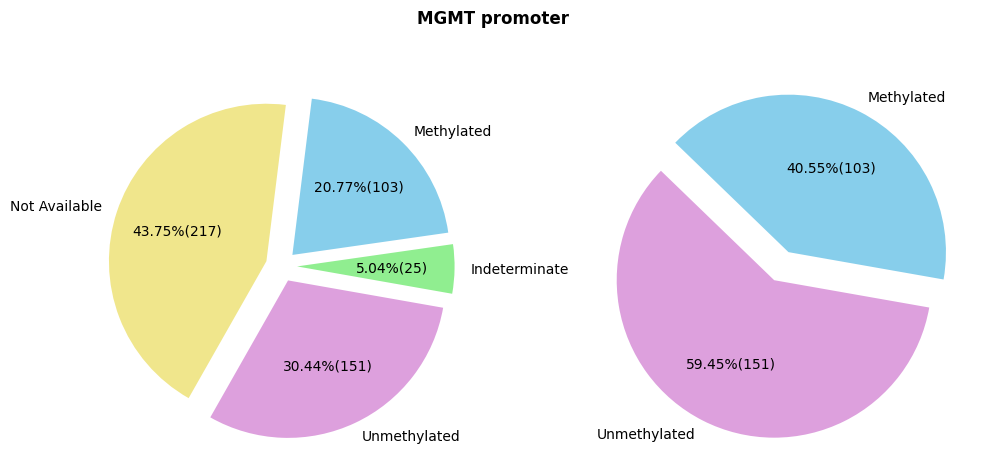

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

dt = glioblastoma2021_OS.groupby(["MGMT"])["ID"].count()
dt.plot.pie(
    ax=ax[0],
    labels=dt.keys(),
    autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
    colors=["lightgreen", "skyblue", "khaki", "plum"],
    explode=[0.1, 0.1, 0.1, 0.1],
    startangle=-10
)
ax[0].set_ylabel("")

dt = glioblastoma2021_OS.loc[(glioblastoma2021_OS["MGMT"]=="Methylated") | (glioblastoma2021_OS["MGMT"]=="Unmethylated")].groupby(["MGMT"])["ID"].count()
dt.plot.pie(
    ax=ax[1],
    labels=dt.keys(),
    autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
    colors=["skyblue", "plum"],
    explode=[0.1, 0.1],
    startangle=-10
)
ax[1].set_ylabel("")

fig.suptitle("MGMT promoter", fontweight='bold')
fig.tight_layout()

In [17]:
MGMT_OS = glioblastoma2021_OS.loc[(glioblastoma2021_OS["MGMT"]=="Methylated") | (glioblastoma2021_OS["MGMT"]=="Unmethylated")]

### Resection data

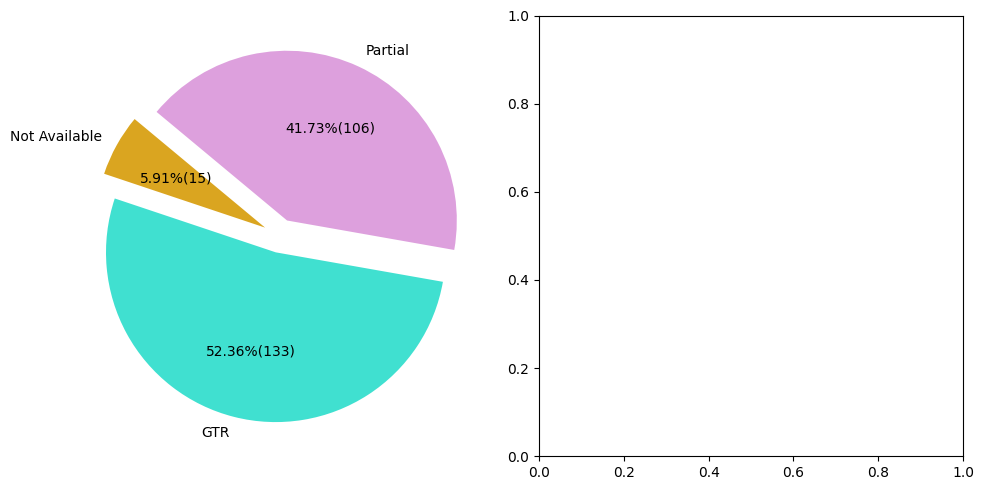

In [18]:
dt = MGMT_OS.groupby(["GTR_over90percent"])["ID"].count()

fig, ax = plt.subplots(1, 2, figsize=(10,5))

dt.plot.pie(
    ax=ax[0],
    labels=["Partial", "Not Available", "GTR"],
    autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
    colors=['plum', 'goldenrod', 'turquoise'],
    explode=[0.1, 0.1, 0.1],
    startangle=-10
)
ax[0].set_ylabel("")

fig.tight_layout()

In [19]:
FINAL_SAMPLE = MGMT_OS.loc[(MGMT_OS["GTR_over90percent"]=="Y") | (MGMT_OS["GTR_over90percent"]=="N")]
print(f"The final sample consists of {len(FINAL_SAMPLE)} GBM Wildtype patients with available survival")
FINAL_SAMPLE.to_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v3.1.csv"), index=None)

The final sample consists of 239 GBM Wildtype patients with available survival


Do all of these patients have available preop imaging data?

In [20]:
total = 0
for subject in FINAL_SAMPLE.iloc:
    ID = subject["ID"]
    df = available_data.loc[available_data["ID"]==ID]
    df = df[["ID","Structural imaging","Automatic Tumor Segmentation", "Corrected Tumor Segmentation"]]
    OK = True if (df["Automatic Tumor Segmentation"].values[0]=="available") and (df["Structural imaging"].values[0]=="available") else False
    if not OK:
        total += 1
        print(f"{ID} without usable imaging data")
print("Number of patients with imaging data: ", len(FINAL_SAMPLE)-total)
print("Number of patients without imaging data: ", total)

Number of patients with imaging data:  239
Number of patients without imaging data:  0


### Continue from here

In [21]:
stream_th = 0
figs_folder = f"Demographics-All"
os.makedirs("../Figures/TDMaps_Grade-IV/"+figs_folder, exist_ok=True)
daysXmonth = 30

TDstats = pd.read_csv(f"../Figures/TDMaps_Grade-IV/demographics-TDMaps_streamTH-{stream_th}.csv")
morphology = pd.read_csv(f"../Figures/TDMaps_Grade-IV/demographics-morphology_mask-tissues.csv")

print(TDstats["1-dead 0-alive"].value_counts().sum())
censored = (TDstats["1-dead 0-alive"]==0).sum()
all = TDstats["1-dead 0-alive"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all,2)}%")

FileNotFoundError: [Errno 2] No such file or directory: '../Figures/TDMaps_Grade-IV/demographics-TDMaps_streamTH-0.csv'

# Tract Density Indices

NameError: name 'TDstats' is not defined

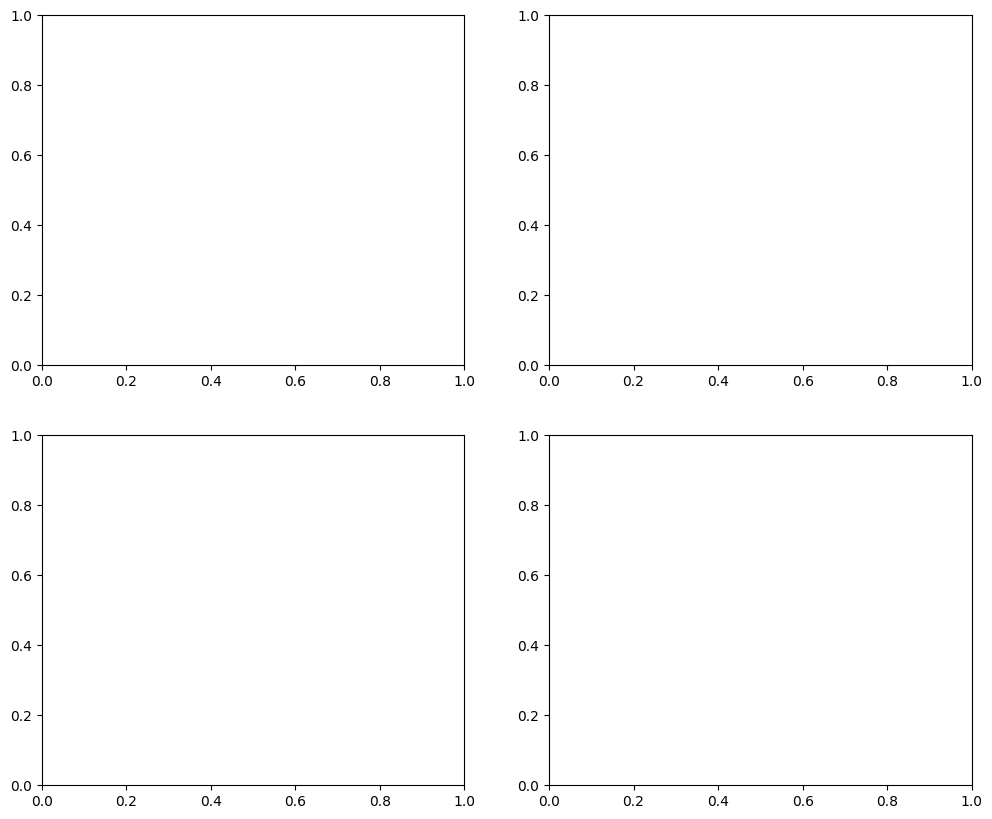

In [ ]:
# Prepare the figure
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 1]})

# Prepare data for percentile lines
tdi_25, tdi_75 = TDstats["Whole TDMap"].quantile(0.25), TDstats["Whole TDMap"].quantile(0.75)
ltdi_25, ltdi_75 = TDstats["Whole lesion TDMap"].quantile(0.25), TDstats["Whole lesion TDMap"].quantile(0.75)

# Histogram for "Whole TDMap"
tdi = TDstats["Whole TDMap"].dropna()
ax[0, 0].hist(tdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True)
ax[0, 0].axvline(tdi_25, color='salmon', linestyle="--", linewidth=1.5, label="p Percentile")
ax[0, 0].axvline(tdi_75, color='royalblue', linestyle="--", linewidth=1.5, label="100-p Percentile")
ax[0, 0].fill_betweenx([0, 1], tdi.min(), tdi_25, color="salmon", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_25, tdi_75, color="lightgray", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_75, tdi.max(), color="royalblue", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].set_xlabel("Tract Density Index (TDI)", fontweight="bold")
ax[0, 0].spines[["top", "right", "left"]].set_visible(False)
ax[0, 0].set_yticks([])
ax[0, 0].set_xticklabels([])
ax[0, 0].legend(loc="upper right", fontsize=12, frameon=False)

# Histogram for "Whole lesion TDMap"
ltdi = TDstats["Whole lesion TDMap"].dropna()
ax[0, 1].hist(ltdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True)
ax[0, 1].axvline(ltdi_25, color='salmon', linestyle="--", linewidth=1.5, label="25th Percentile")
ax[0, 1].axvline(ltdi_75, color='royalblue', linestyle="--", linewidth=1.5, label="75th Percentile")
ax[0, 1].fill_betweenx([0, 1], ltdi.min(), ltdi_25, color="salmon", alpha=0.2, transform=ax[0, 1].get_xaxis_transform())
ax[0, 1].fill_betweenx([0, 1], ltdi_25, ltdi_75, color="lightgray", alpha=0.2, transform=ax[0, 1].get_xaxis_transform())
ax[0, 1].fill_betweenx([0, 1], ltdi_75, ltdi.max(), color="royalblue", alpha=0.2, transform=ax[0, 1].get_xaxis_transform())
ax[0, 1].set_xlabel("Lesion-Tract Density Index (L-TDI)", fontweight="bold")
ax[0, 1].spines[["top", "right", "left"]].set_visible(False)
ax[0, 1].set_yticks([])
ax[0, 1].set_xticklabels([])

# Scatter plot for the relationship between the two variables
ax[1, 0].scatter(
    TDstats["Whole TDMap"], 
    TDstats["Whole lesion TDMap"], 
    alpha=0.7, color="mediumseagreen", edgecolor="black"
)
ax[1, 0].set_xlabel("Tract Density Index (TDI)", fontweight="bold")
ax[1, 0].set_ylabel("Lesion-Tract Density Index (L-TDI)", fontweight="bold")
ax[1, 0].spines[["top", "right"]].set_visible(False)
#ax[1, 0].set_xticklabels([])
#ax[1, 0].set_yticklabels([])

x = TDstats["Whole TDMap"].dropna()
y = TDstats["Whole lesion TDMap"].dropna()
slope, intercept, r_value, _, _ = linregress(x, y)
ax[1, 0].plot(x, slope * x + intercept, color="black", linestyle="-", label=f"r = {r_value:.3f}", linewidth=2)
ax[1, 0].legend(loc="upper left", fontsize=12, frameon=False)

# Hide empty subplot (bottom right)
ax[1, 1].axis("off")

# Adjust layout
fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/TDIndices.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')